ANN YERİNE LSTM KULLANARAK KESİNTİSİZ UÇUŞ SİMÜLASYON VERİLERİ İLE ÇALIŞMAK

GÖREV 1 -Verileri oluştur-

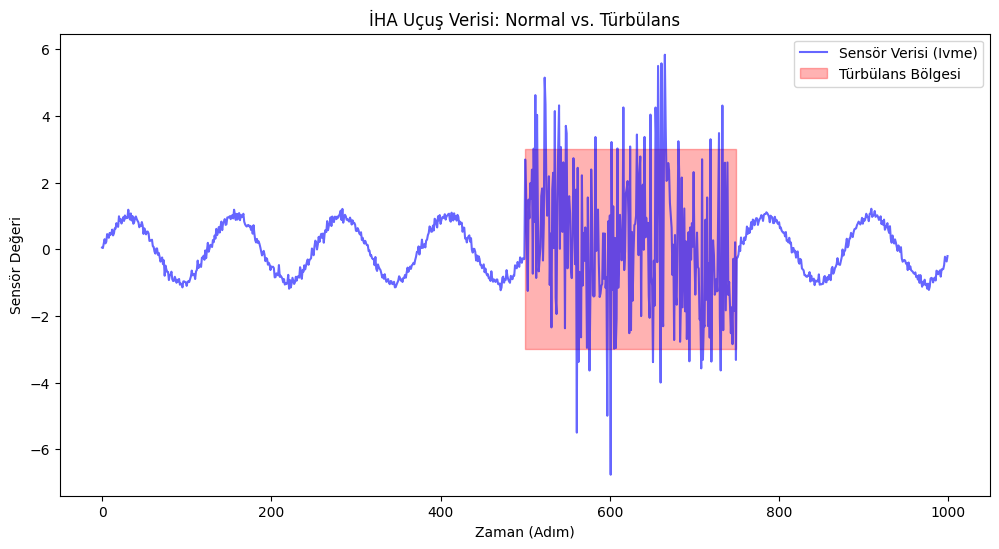

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Tekrarlanabilirlik için
np.random.seed(42)

# --- AYARLAR ---
TOTAL_STEPS = 1000       # Toplam veri noktası (saniye gibi düşün)
TURBULENCE_START = 500   # Türbülans nerede başlasın
TURBULENCE_END = 750     # Türbülans nerede bitsin

# 1. TEMEL SİNYAL (Normal Uçuş - Sinüs Dalgası)
# İHA hafifçe sağa sola yatıyor gibi düşün (Rüzgar salınımı)
time = np.linspace(0, 50, TOTAL_STEPS)
base_signal = np.sin(time)

# 2. GÜRÜLTÜ EKLEME
# Önce her yere 'hafif' sensör gürültüsü ekle
noise = np.random.normal(0, 0.1, TOTAL_STEPS)

# Şimdi o aralığa 'ŞİDDETLİ' türbülans gürültüsü ekle
turbulence_noise = np.random.normal(0, 2.0, TURBULENCE_END - TURBULENCE_START)
noise[TURBULENCE_START:TURBULENCE_END] = turbulence_noise

# 3. MONTAJ (Sinyal + Gürültü)
sensor_data = base_signal + noise

# 4. ETİKETLEME (0: Normal, 1: Türbülans)
labels = np.zeros(TOTAL_STEPS)
labels[TURBULENCE_START:TURBULENCE_END] = 1

# --- GÖRSELLEŞTİRME (Gözümüzle Görelim) ---
plt.figure(figsize=(12, 6))
plt.plot(sensor_data, label='Sensör Verisi (Ivme)', color='blue', alpha=0.6)
plt.fill_between(range(TOTAL_STEPS), -3, 3, where=(labels==1), color='red', alpha=0.3, label='Türbülans Bölgesi')
plt.title("İHA Uçuş Verisi: Normal vs. Türbülans")
plt.xlabel("Zaman (Adım)")
plt.ylabel("Sensör Değeri")
plt.legend()
plt.show()

# DataFrame'e çevirip hazır edelim
df_flight = pd.DataFrame({
    'Sensor_Value': sensor_data,
    'Label': labels
})

GÖREV 2 -VERİYİ 2 BOYUTLUDAN ÇIKARIP 3 BOYUTLU HÂLE GETİRME

In [16]:
# --- AYARLAR ---
WINDOW_SIZE = 50  # Model geçmiş 50 veriye bakacak

def create_sliding_window(data, labels, window_size):
    X_list = []
    y_list = []
    
    # Döngü 50. veriden başlar (çünkü öncesinde 50 tane geçmiş veri yok!)
    for i in range(window_size, len(data)):
        
        # PENCERE (X): i'den önceki 50 veriyi al
        # Örn: i=50 ise, 0'dan 49'a kadar olanları al
        window = data[i-window_size:i]
        
        # HEDEF (y): Tam şu anki (i) etiket nedir?
        target = labels[i]
        
        X_list.append(window)
        y_list.append(target)
        
    return np.array(X_list), np.array(y_list)

# --- FONKSİYONU KULLANMA ---
# df_flight'tan veriyi çek (Pandas Series -> Numpy Array)
raw_data = df_flight['Sensor_Value'].values
raw_labels = df_flight['Label'].values

# Dönüştür
X, y = create_sliding_window(raw_data, raw_labels, WINDOW_SIZE)

# --- KRİTİK ADIM: 3. BOYUTU EKLEME ---
# LSTM veriyi (Örnek, Zaman, Özellik) ister.
# Şu an elimizde (950, 50) var. Bunu (950, 50, 1) yapmalıyız.
# Çünkü her adımda sadece "1" özellik (sensör değeri) var.
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

print(f"Orijinal Veri Sayısı: {len(raw_data)}")
print(f"X Şekli (Samples, TimeSteps, Features): {X.shape}")
print(f"y Şekli: {y.shape}")

Orijinal Veri Sayısı: 1000
X Şekli (Samples, TimeSteps, Features): (950, 50, 1)
y Şekli: (950,)


GÖREV 3 -MODELİ KURMA VE EĞİTME-

In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# --- VERİYİ BÖLME ---
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

# --- MODELİ KURMA ---
model = Sequential()
model.add(Input(shape=(WINDOW_SIZE, 1)))
model.add(LSTM(64))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy", "precision", "recall"])
model.summary()
# --- MODELİ EĞİTME ---
history = model.fit(xtrain, ytrain, epochs=20, batch_size=32, validation_data=(xtest, ytest))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7211 - loss: 0.6424 - precision: 0.4600 - recall: 0.3450 - val_accuracy: 0.7947 - val_loss: 0.5544 - val_precision: 1.0000 - val_recall: 0.2200
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7763 - loss: 0.4111 - precision: 0.9688 - recall: 0.1550 - val_accuracy: 0.9316 - val_loss: 0.2908 - val_precision: 0.9512 - val_recall: 0.7800
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9487 - loss: 0.1933 - precision: 0.8927 - recall: 0.9150 - val_accuracy: 0.9000 - val_loss: 0.2225 - val_precision: 0.7541 - val_recall: 0.9200
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9500 - loss: 0.1465 - precision: 0.8821 - recall: 0.9350 - val_accuracy: 0.9158 - val_loss: 0.1877 - val_precision: 0.8036 - val_recall: 0.9000
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9605 - loss: 0.1210 - precision: 0.9048 - recall: 0.9500 - val_accuracy: 0.9368 - val_loss: 0.1577 